# ID and Isolation ROC curves

We want to compare the performance of the elecron MVA that includes isolation with the performance of a two-step approach that applies an MVA without isolation components and a combined isolation cut in sequence.

First the imports:

In [84]:
import uproot
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np

Let's load some data: any ROOT file produced by the ElectronMVANtuplizer will do.

In [74]:
f = uproot.open("train_eval.root")

In [75]:
tree = f["ntuplizer/tree"]

In [243]:
branches = ["ele_pt",
            "scl_eta",
            "Fall17NoIsoV2RawVals",
            "Fall17IsoV2RawVals",
            "matchedToGenEle",
            "ele_pfPhotonIso",
            "ele_pfChargedHadIso",
            "ele_pfNeutralHadIso"]

We don't load all the entries to save time:

In [ ]:
df = tree.pandas.df(branches=branches, entrystop=10000000)

Let's restrict ourselves to the EB_1 bin:

In [244]:
df = df.query("ele_pt > 10 and abs(scl_eta) < 0.8")

Signal and background definition:

In [ ]:
df = df.query("matchedToGenEle != 2")
df["matchedToGenEle"] = df["matchedToGenEle"] == 1

n_sig = len(df.query("matchedToGenEle"))
n_bkg = len(df.query("not matchedToGenEle"))

Let's calculate the combined relative isolation. In reality, you will do a pileup correction with effective areas and $\rho$, but for the proof of concept we skip that for now.

We invert the sign such that background is on the left as sklearn expects.
We also calculate the isolation quantiles, which we use later.

In [288]:
df["IsoSum"] = -(df.ele_pfPhotonIso + df.ele_pfChargedHadIso + df.ele_pfNeutralHadIso)/df.ele_pt
q = np.linspace(0, 0.2, 26)[1:-1]
iso_quantiles = df.IsoSum.quantile(q)

Little helper function to plot ROC curves using `metrics.roc_curve`:

In [289]:
def plot_roc(df, x, label=None):
    fpr, tpr, _ = metrics.roc_curve(df.matchedToGenEle, df[x], pos_label=1)
    plt.semilogy(tpr[tpr>0.7], fpr[tpr>0.7], label=x if label is None else label)

Now the tricky part: to get to a __true ROC curve for MVA and isolation sequentially__, we have to consider that these two estimators are correlated. We can't just determine ROC curves individually and multiply them here. Instead, we have to basically calculate a "ROC plane" wich is parametrized by two working points: one for the MVA and one for the isolation. The optimal ROC curve will be the lower contour of the plane.

To calculate the ROC plane, we need to somehow sample points from it. Sampling curves from it is very easy, we just fix the isolation cut and get the ROC curve for the MVA, then multiply. To get the full plane, we need to do this for an array of isolation cuts. That's why we got the quantiles before to loop over now:

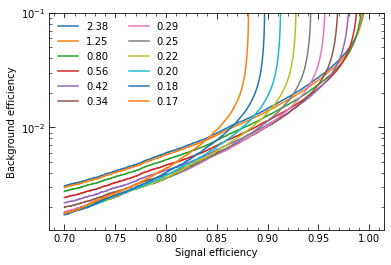

In [290]:
grid_df = pd.DataFrame()

i = 0
for cut in iso_quantiles:
    df_cut = df[df.IsoSum > cut]
    sig_eff = len(df_cut.query("matchedToGenEle")) * 1./n_sig
    bkg_eff = len(df_cut.query("not matchedToGenEle")) * 1./n_bkg
    fpr, tpr, _ = metrics.roc_curve(df_cut.matchedToGenEle, df_cut["Fall17NoIsoV2RawVals"], pos_label=1)
    tpr = sig_eff * tpr
    fpr = bkg_eff * fpr
    if i % 2 == 0:
        plt.semilogy(tpr[tpr>0.7], fpr[tpr>0.7], label="{0:.2f}".format(-cut))
    tmp_df = pd.DataFrame(data={"tpr":tpr, "fpr":fpr})
    grid_df = pd.concat([grid_df, tmp_df])
    i = i+1
    
    
plt.ylim(plt.ylim()[0], 0.1)
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.legend(loc="upper left", ncol=2)
plt.show()

That looks messy! We approximated the "ROC plane" with a bunch of curves. But from the plot we can see why it was important that we do this two-dimensional scan: what the best isolation cut is depends on the efficiency and therefore on the MVA cut. You can see this by taking a look at the color (isolation cut) at the lower edge of the "plane", which corresponds to optimally tuned working points.

But of course we don't want to show all of these curves, so we find the lower contour by binning in `tpr` all points from all curves together and finding the minimum in `fpr` for each bin. That's how we get the optimal ROC curve for the two-step approach.

In [293]:
tpr_bins = np.linspace(0.7, 1, 200)
grid_df["tpr_bin"] = pd.cut(grid_df["tpr"], tpr_bins)
fpr = grid_df.groupby("tpr_bin").fpr.min().values

For the true positive rate, we just take the centers of out `tpr` bins:

In [294]:
tpr = (tpr_bins[1:]+tpr_bins[:-1])/2.

Time to make the plot!

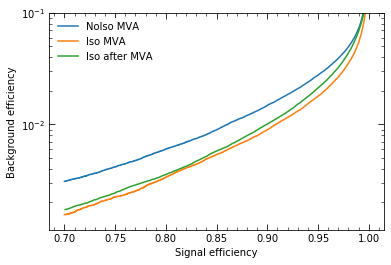

In [295]:
plot_roc(df, "Fall17NoIsoV2RawVals", label="NoIso MVA")
plot_roc(df, "Fall17IsoV2RawVals", label="Iso MVA")
plt.plot(tpr, fpr, label="Iso after MVA")
plt.legend(loc="upper left")
plt.ylim(plt.ylim()[0], 0.1)
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.show()

An interesting cross-check would be to estimate the two-step ROC by combining MVA and isolation to one classifier with logistic regression, which can't explot the correlation between the two variables:

In [296]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(solver='lbfgs').fit(df[["Fall17NoIsoV2RawVals", "IsoSum"]], -df.matchedToGenEle)
df["Reg"] = reg.predict_proba(df[["Fall17NoIsoV2RawVals", "IsoSum"]])

Let's add it to the ROC curve:

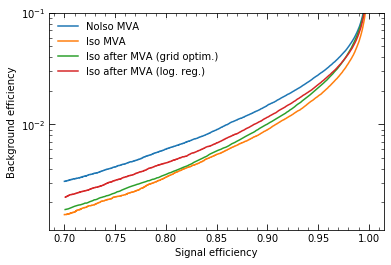

In [297]:
plot_roc(df, "Fall17NoIsoV2RawVals", label="NoIso MVA")
plot_roc(df, "Fall17IsoV2RawVals", label="Iso MVA")
plt.plot(tpr, fpr, label="Iso after MVA (grid optim.)")
plot_roc(df, "Reg", label="Iso after MVA (log. reg.)")
plt.legend(loc="upper left")
plt.ylim(plt.ylim()[0], 0.1)
plt.xlabel("Signal efficiency")
plt.ylabel("Background efficiency")
plt.show()

As expected, it is a bit better than the MVA alone, but doesn't match the optimal ROC curve the got by sampling the two dimensional grid of working points.

Actually, you can interpret earch curve on this line as one step in the progression of including the isolation components in the MVA:

* __Blue:__ no isolation information
* __Red:__ MVA ID and relative isolation sum are used, but not their correlation
* __Green:__ MVA ID, relative isolation sum and the correlation of the two is used
* __Yellow:__ MVA ID that includes isolation components: correlation of the isolation components with the individual ID variables can be used